In [1]:
### Loading Video
import os
import av
import math
from torchvision.io import read_video
from torchvision.transforms.functional import to_pil_image

left_video = os.path.join("Nov30", "left.mp4")
right_video = os.path.join("Nov30", "right.mp4")


def load_video(video_path, sample_index):
    video, audio, meta = read_video(video_path, pts_unit="sec", output_format="TCHW")
    frame_counts = len(video)
    fps = meta['video_fps']
    print(frame_counts, fps)
    sample_frame = to_pil_image(video[sample_index])
    sample_frame = sample_frame.rotate(-90, expand=True)
    return video, frame_counts, fps, sample_frame
            

In [2]:
frame_index = 31

32 29.882131592053568


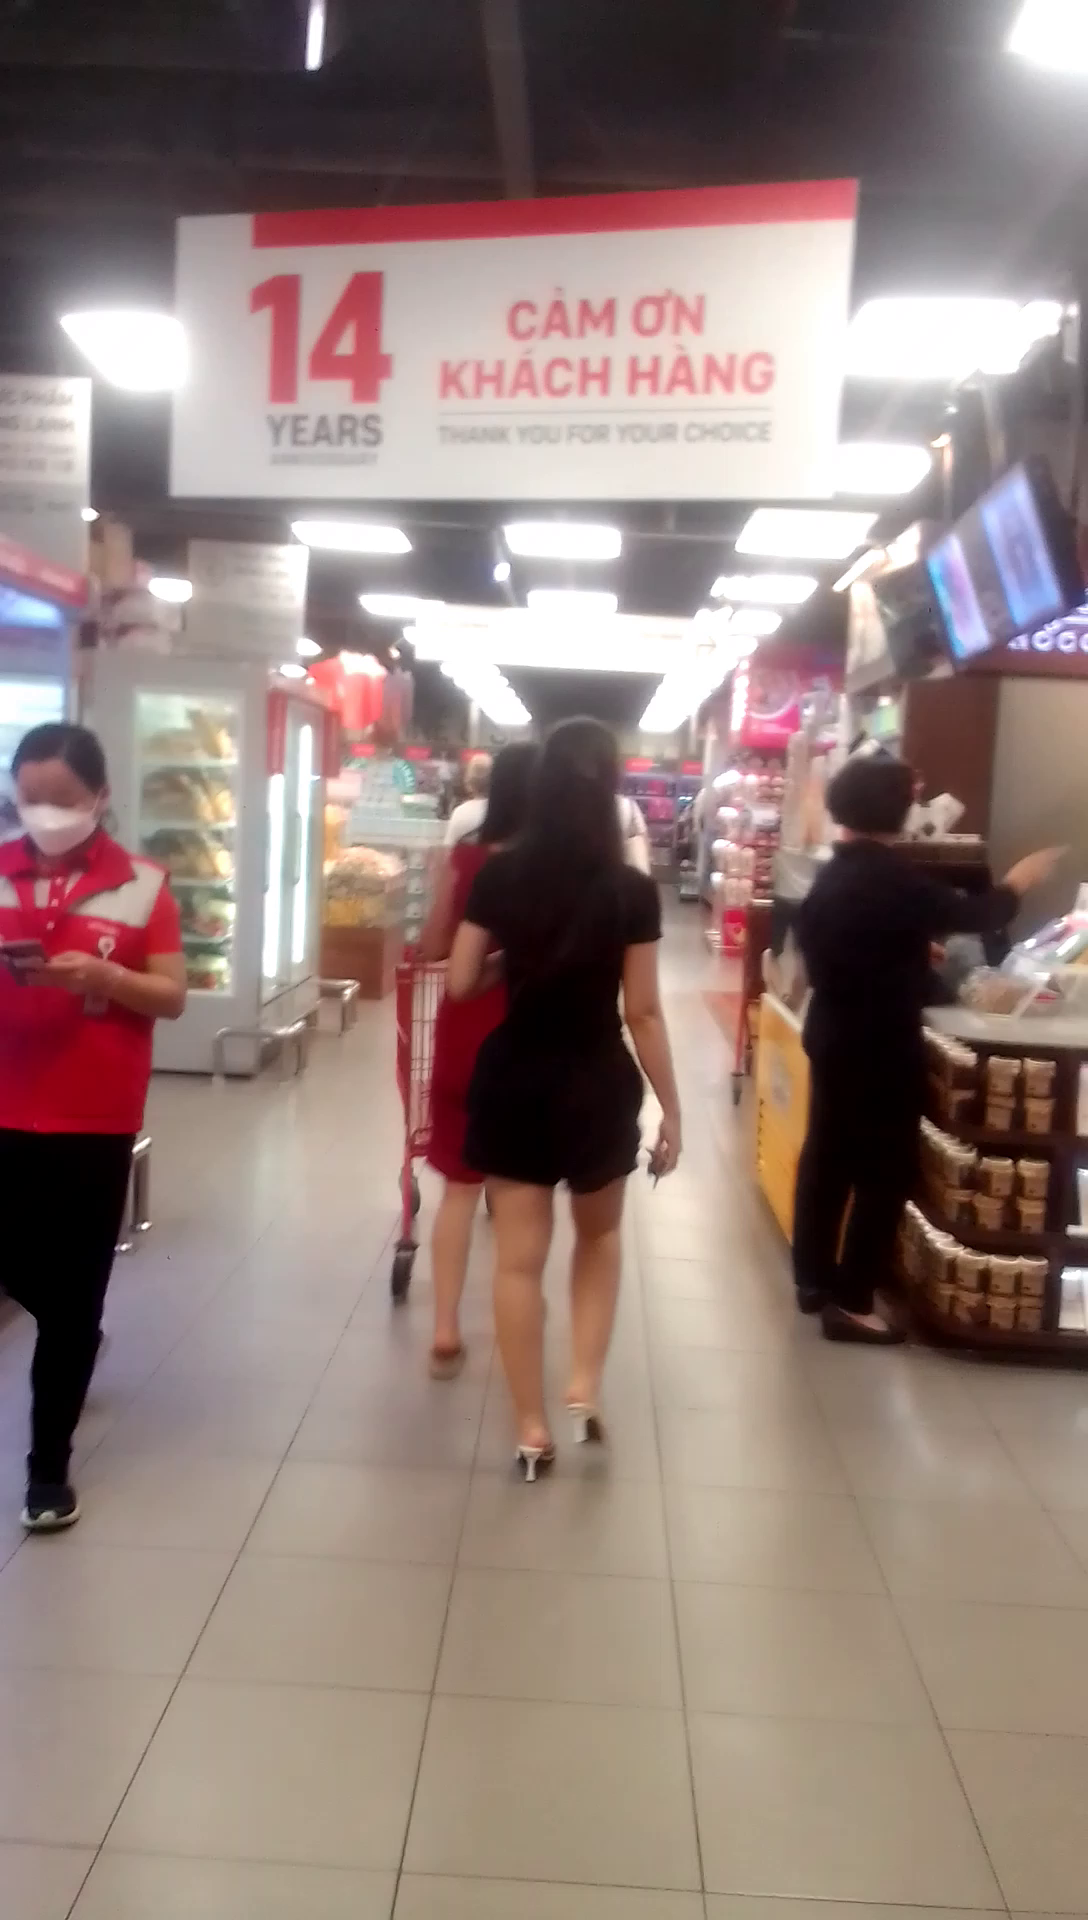

In [3]:
left_vid, left_counts, left_fps, left_sample = load_video(left_video, frame_index)
left_sample

32 29.8804780876494


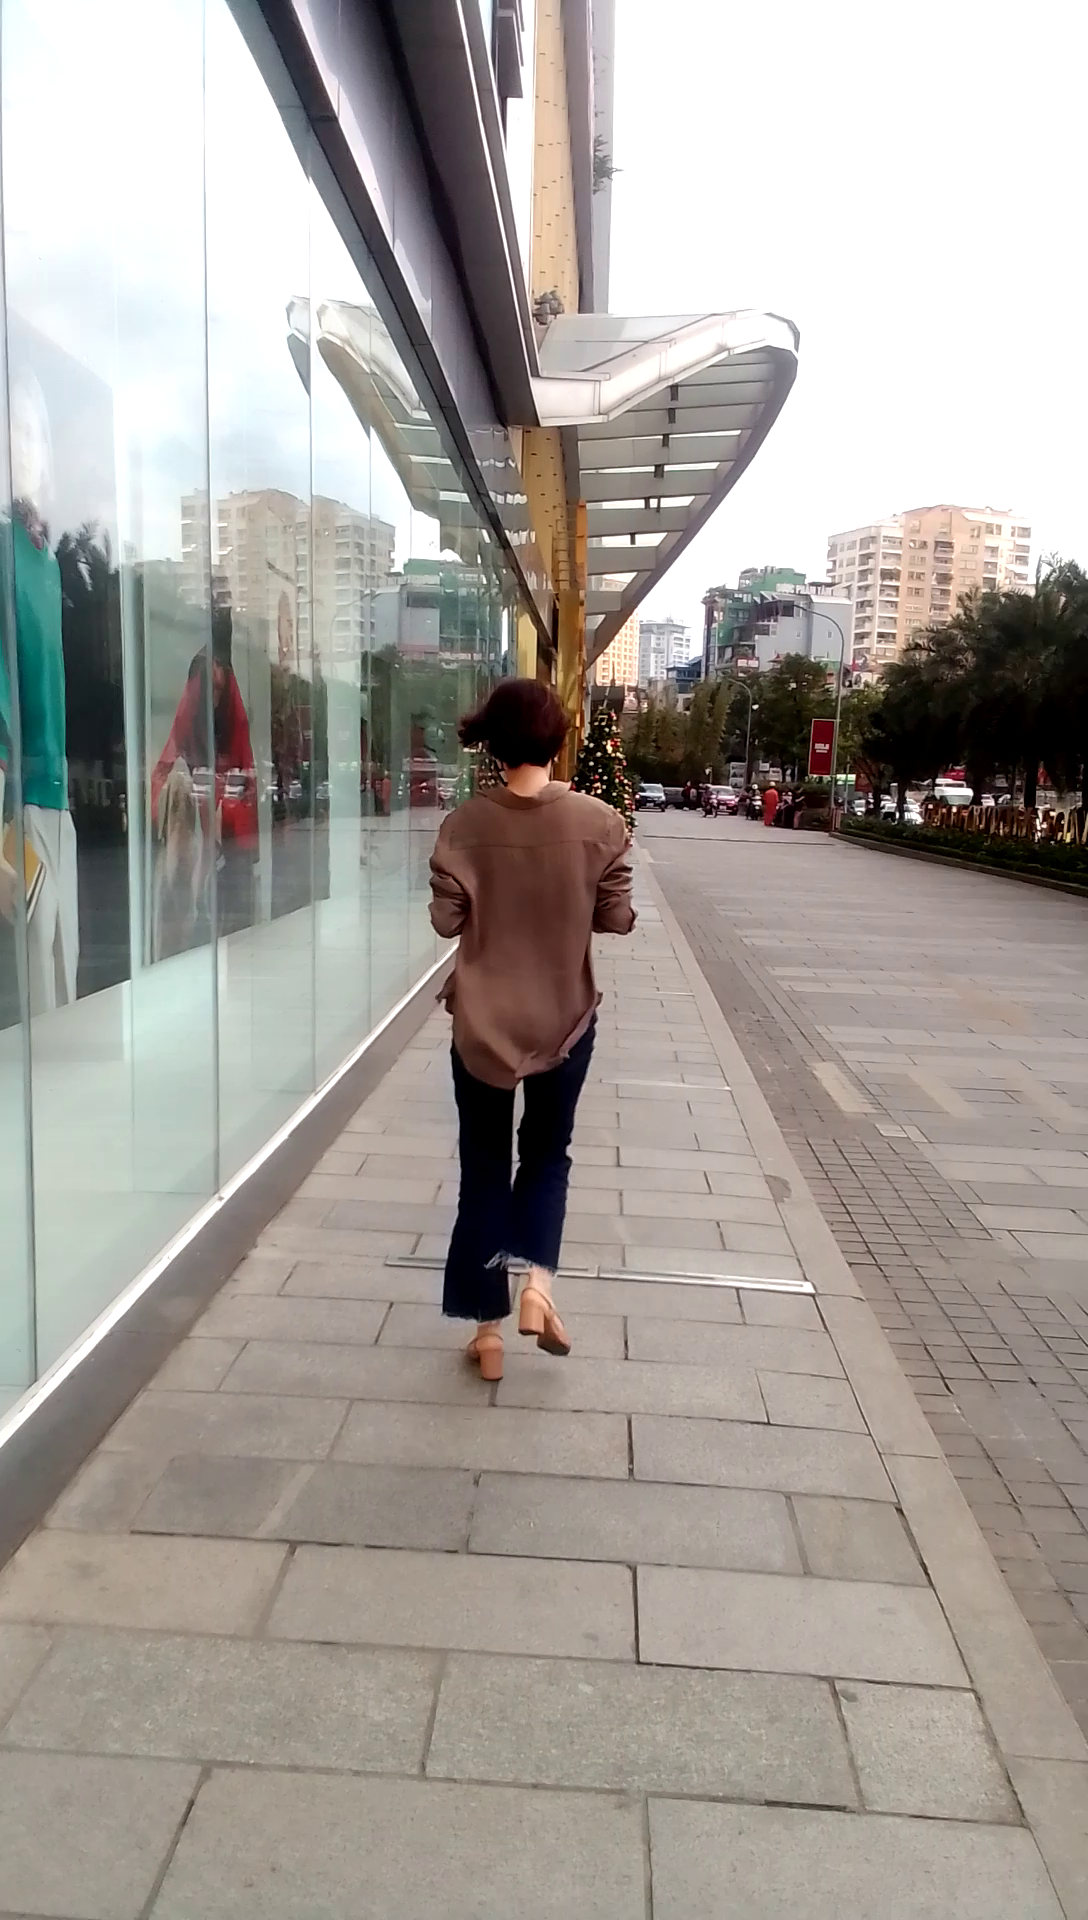

In [4]:
right_vid, right_counts, right_fps, right_sample = load_video(right_video, frame_index)
right_sample

In [8]:
bbox = [ 596.5524,  724.8996,  704.1814, 1041.8312]

def center(bbox):
    center_x = (bbox[2] + bbox[0])/2
    center_y = (bbox[3] + bbox[1])/2
    center = [center_x, center_y]
    return center

def dfc(pic, bbox):
    pic_width = pic.width
    pic_height = pic.height
    
    pic_center = center([0,0, pic_width, pic_height])
    bbox_center = center(bbox)
    
    x_dif = bbox_center[0] - pic_center[0]
    y_dif = bbox_center[1] - pic_center[1]
    distance = math.sqrt(x_dif * x_dif + y_dif * y_dif)
    area = abs(x_dif * y_dif)
    return distance, area

dfc(left_sample, bbox)
    

(131.09835747548476, 8151.384834739996)

In [9]:
def bodyRatio(kp):
    ls = kp[0][5]
    rs = kp[0][6]

    lh = kp[0][11]
    rh = kp[0][12]

    la = kp[0][15]
    ra = kp[0][16]

    def legToBack(s, h, a):
        return (a-h)/(h-s)

    def hipToShoulder(ls, rs, lh, rh):
        return (rh-lh)/(rs-ls)

    legRatio = legToBack(ls[1], lh[1], la[1])
    hipRatio = hipToShoulder(ls[0], rs[0], lh[0], rh[0])
    
    leg_back = round(legRatio.item(), 3)
    hip_shoulder = round( hipRatio.item(), 3)
    score = round(leg_back * hip_shoulder, 3)
    
    return score, leg_back, hip_shoulder

In [20]:
from PIL import ImageDraw, ImageFont

def addData(image, data): 
    width = image.width
    sample = image.copy()
    draw = ImageDraw.Draw(sample) 

    draw.rectangle(
        [(width/2-200,400), (width/2+200, 530)], 
        fill="#40389F", 
        outline=None
    )

    title_font = ImageFont.truetype("Roboto-Bold.ttf", 31)
    data_font = ImageFont.truetype("Roboto-Bold.ttf", 41)

    draw.text(
        (width/2-120,420),
        "Body Matrix Score",
        fill="#FAFF00",
        font=title_font,
        align="center"
    )

    draw.text(
        (width/2-40,460),
        data,
        fill="#FAFF00",
        font=data_font,
        align="center"
    )


    return sample

In [21]:
### Loading Keypoints Models
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
model =  keypointrcnn_resnet50_fpn(weights=weights)
transforms = weights.transforms()

model.eval().to("cpu")

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [22]:
### Frame Keypoints Prediction and Visualization
import torch
from torchvision.utils import draw_keypoints, draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor

def detect(frame, min_scores):
    ### Make Predictions on Frame
    body_matrix = transforms(frame)
    predictions = model([body_matrix.to("cpu")])

    ### Extract Boxes, Scores and Keypoints from frame
    boxes = predictions[0]['boxes']
    keypoints = predictions[0]['keypoints']
    scores = predictions[0]['scores']

    ### Filter for the main Bounding Box and Keypoints
    idx = torch.where(scores > min_scores)
    
    main_boxes = torch.unsqueeze(boxes[idx], dim=1)
    main_index = 0
    max_focus = 6
    
    for selector, box in enumerate(main_boxes):
        bbox = [
            box[0][0].item(), 
            box[0][1].item(),
            box[0][2].item(),
            box[0][3].item()
        ]
        
        distance, area = dfc(frame, bbox)
        focus = area/(distance*10)
        
        # print(f"Focus: {focus}, Selector: {selector}")
        
        if focus < max_focus :
            max_focus = focus
            main_index = selector
    
    bx = torch.unsqueeze(boxes[idx][main_index], dim=0)
    kp = torch.unsqueeze(keypoints[idx][main_index], dim=0)
    score, legRatio, hipRatio = bodyRatio(kp)
    
    labels = [f'SCORE: {score}']
    # print(f"Main Index: {main_index}, Score: {score}")
    
    ### Draw Keypoints and Bounding Boxes
    tensor_image = pil_to_tensor(frame)
    keypoints_image = draw_keypoints(tensor_image, kp, colors="yellow", radius=3)
    
    final_image = draw_bounding_boxes(
        keypoints_image, 
        bx, 
        colors="blue", 
        fill=True, 
    )
    
    pil_image = to_pil_image(final_image)
    final_image = addData(pil_image, f"{score}")

    return final_image

In [23]:
from PIL import Image

def stitch(left_frame, right_frame):
    left_cal = detect(left_frame, 0.9)
    right_cal = detect(right_frame, 0.9)

    width = left_cal.width + right_cal.width
    height = left_cal.height

    left_right = Image.new("RGB",(width, height))
    left_right.paste(im=left_cal, box=(0,0))
    left_right.paste(im=right_cal, box=(left_cal.width, 0))
    return left_right

output = stitch(left_sample, right_sample)

Focus: 16.689668311279686, Selector: 0
Focus: 1.6740741490546025, Selector: 1
Focus: 8.512725958969092, Selector: 2
Focus: 6.7754193505821165, Selector: 3
Main Index: 1, Score: 1.048
Focus: 1.450861393598953, Selector: 0
Focus: 12.850142559716557, Selector: 1
Main Index: 0, Score: 0.893


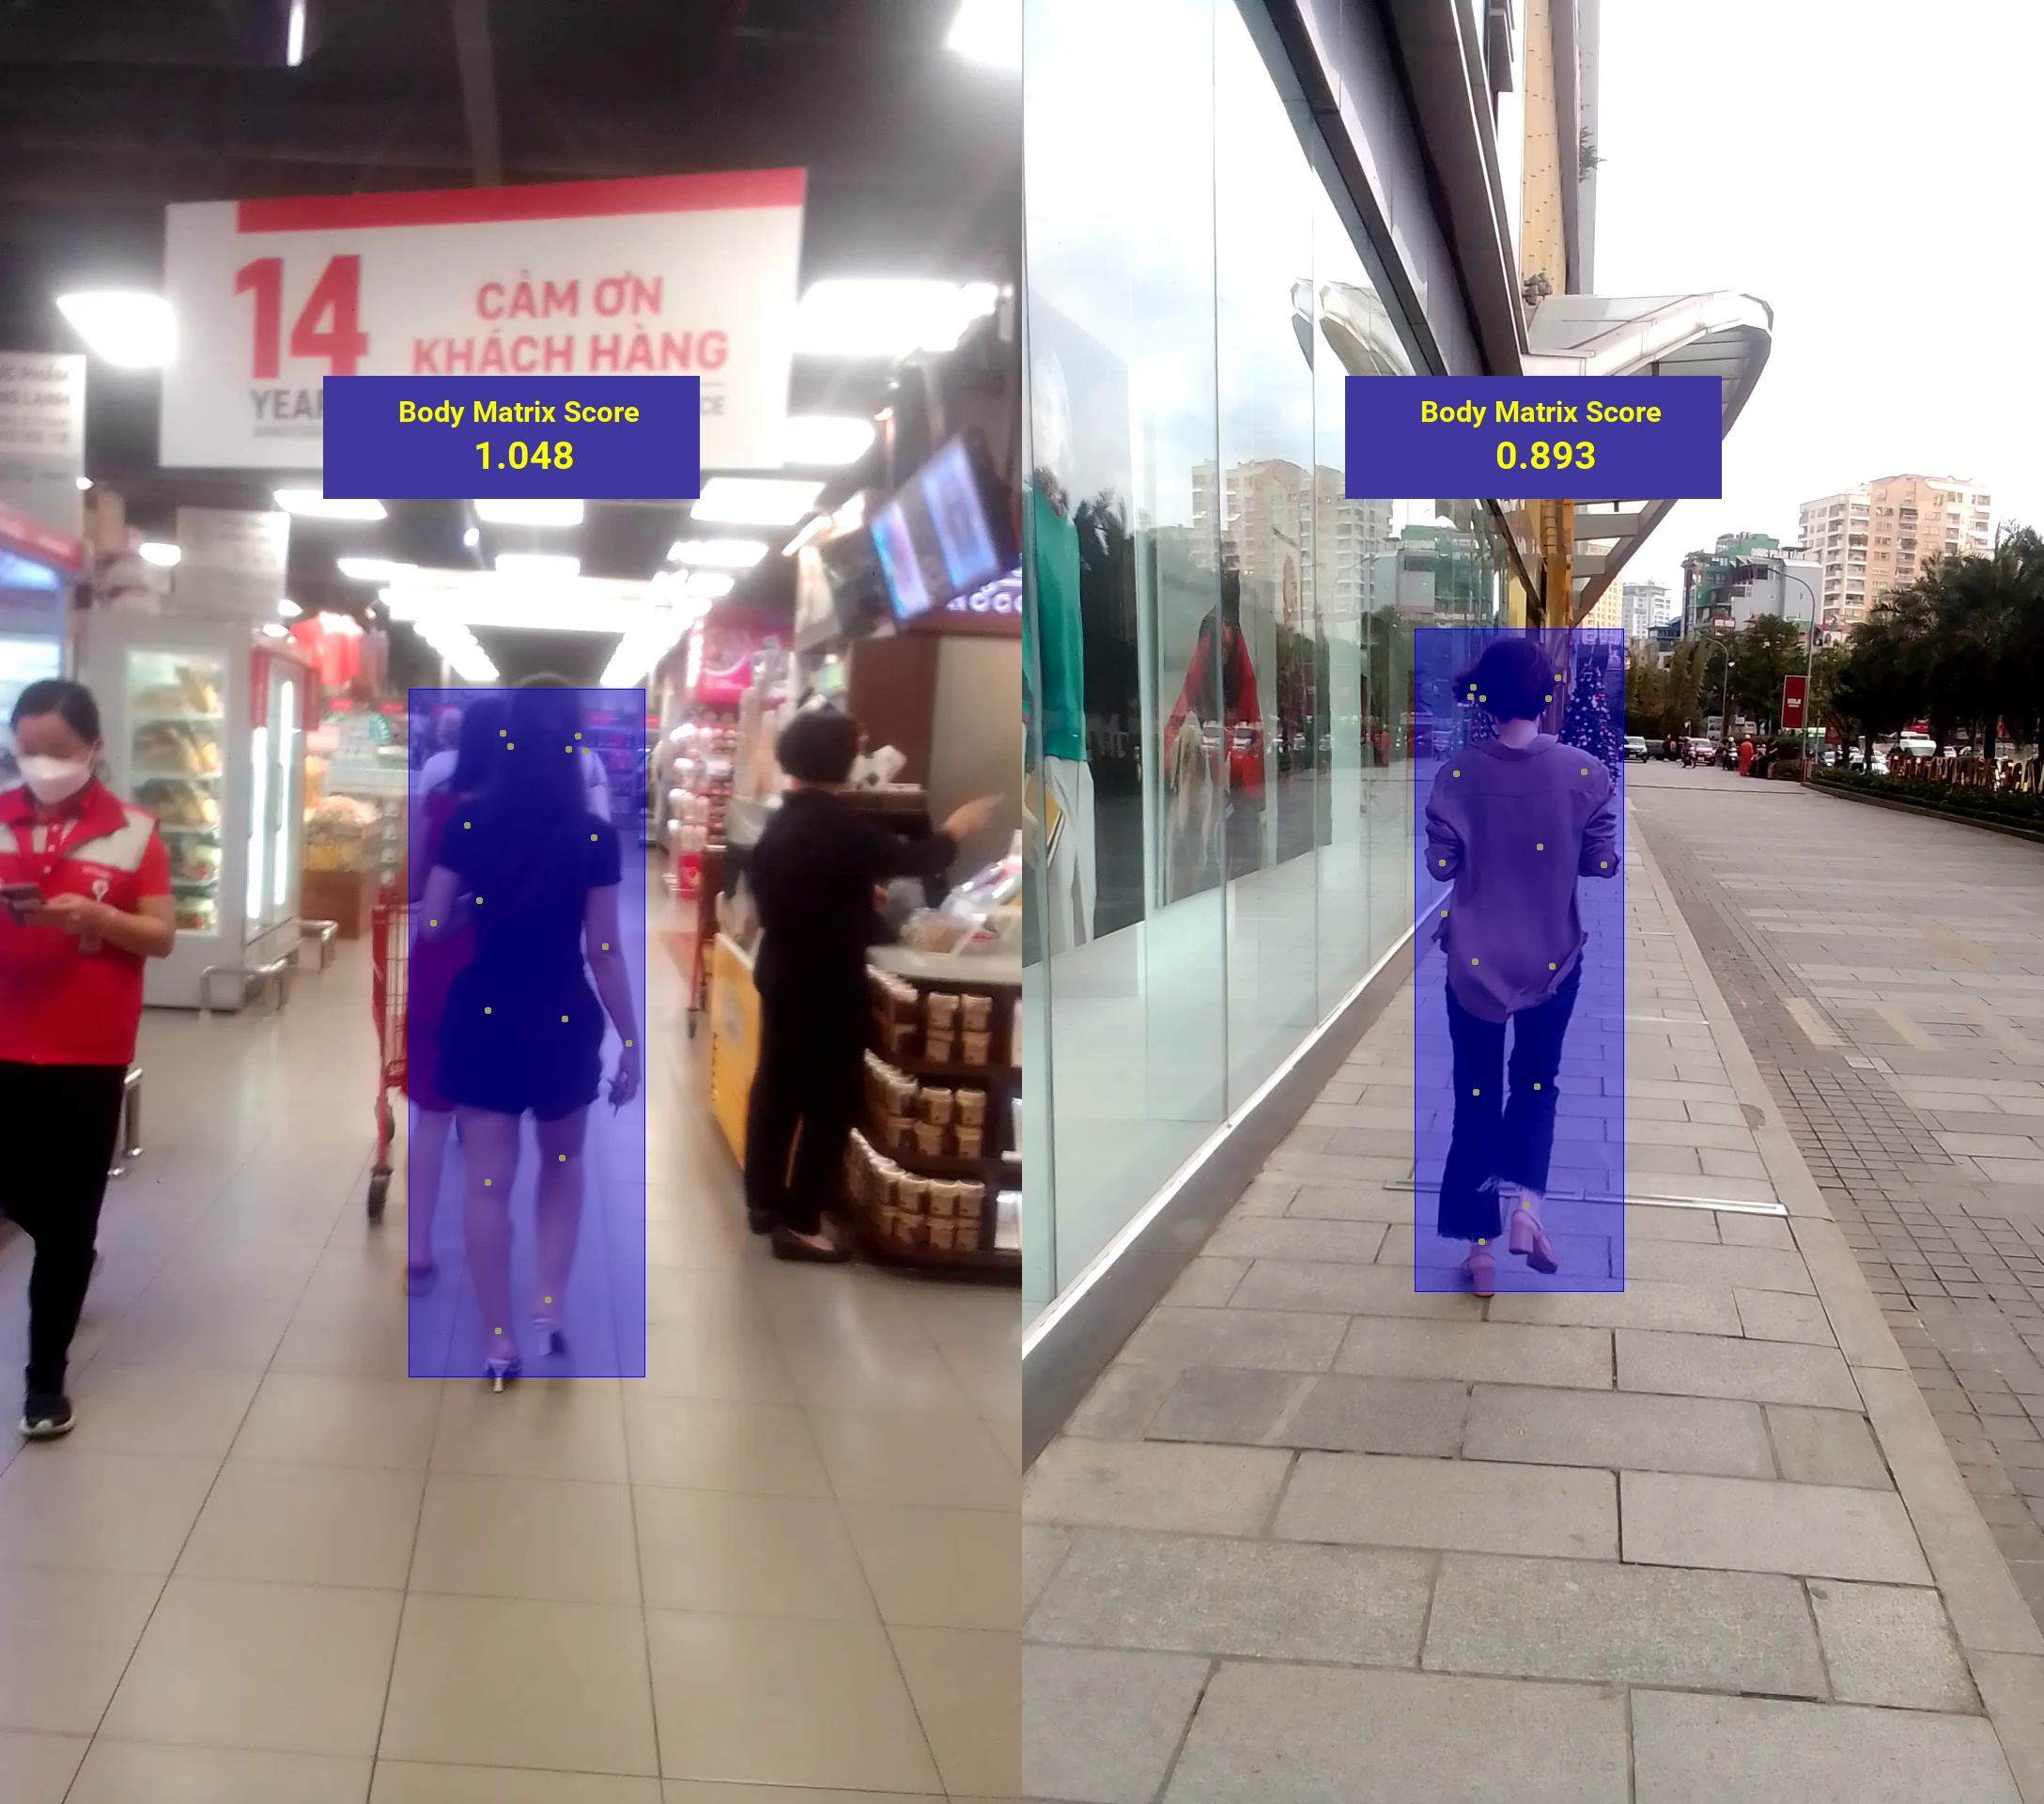

In [24]:
output

In [25]:
output.save("body_matrix_scores_02.jpg")

In [26]:
def video_processing(left_vid, right_vid):
    frame_counts = min(len(left_vid), len(right_vid))
    container = av.open("body_matrix_scores_02.mp4", mode="w")
    stream = container.add_stream("mpeg4", rate=math.floor(left_fps))
    stream.width = output.width
    stream.height = output.height
    
    def encode(image):
        frame = av.VideoFrame.from_image(image)
        for packet in stream.encode(frame):
            container.mux(packet)
    
    for idx in range(frame_counts):
        print(f"Processing {idx+1} of {frame_counts} ", end="\r")
        
        left_frame = to_pil_image(left_vid[idx])
        left_frame = left_frame.rotate(-90, expand=True)
        
        right_frame = to_pil_image(right_vid[idx])
        right_frame = right_frame.rotate(-90, expand=True)
        
        stitched_frame = stitch(left_frame, right_frame)
        encode(stitched_frame)
    
    container.close()

In [27]:
video_processing(left_vid, right_vid)

Focus: 5.809290350171299, Selector: 0
Focus: 2.2570099236133263, Selector: 1
Focus: 5.120319219402049, Selector: 2
Focus: 6.217763701129978, Selector: 3
Main Index: 1, Score: 1.096
Focus: 4.899152117634488, Selector: 0
Focus: 10.41306174924981, Selector: 1
Main Index: 0, Score: 0.825
Focus: 6.254000554476997, Selector: 0
Focus: 5.809238526891566, Selector: 1
Focus: 2.130532253608004, Selector: 2
Focus: 5.729804896266436, Selector: 3
Main Index: 2, Score: 1.15
Focus: 2.4029797423943338, Selector: 0
Focus: 12.416962562078975, Selector: 1
Main Index: 0, Score: 0.848
Focus: 5.8569841516510746, Selector: 0
Focus: 5.789932879972995, Selector: 1
Focus: 2.2970914353722134, Selector: 2
Focus: 5.904629805105449, Selector: 3
Main Index: 2, Score: 1.186
Focus: 3.198064801593952, Selector: 0
Focus: 12.04384546143084, Selector: 1
Main Index: 0, Score: 0.899
Focus: 5.844234257564908, Selector: 0
Focus: 5.64229929637255, Selector: 1
Focus: 3.3260257911279987, Selector: 2
Focus: 6.250405733179579, Sele

Focus: 2.1680895585795263, Selector: 0
Focus: 14.294161607740204, Selector: 1
Main Index: 0, Score: 0.859
Focus: 18.943472277127732, Selector: 0
Focus: 2.8038328378964827, Selector: 1
Focus: 10.759428856974978, Selector: 2
Focus: 5.550561022628018, Selector: 3
Main Index: 1, Score: 1.12
Focus: 2.895343453670055, Selector: 0
Focus: 14.307079491906338, Selector: 1
Main Index: 0, Score: 0.971
Focus: 17.746263213093478, Selector: 0
Focus: 3.0447080994603395, Selector: 1
Focus: 11.855181406367278, Selector: 2
Main Index: 1, Score: 0.986
Focus: 2.0718853081507125, Selector: 0
Focus: 14.025879105595996, Selector: 1
Main Index: 0, Score: 0.905
Focus: 16.22208720890913, Selector: 0
Focus: 1.3441513271853063, Selector: 1
Focus: 8.934159989812121, Selector: 2
Focus: 7.3814285620301625, Selector: 3
Main Index: 1, Score: 1.008
Focus: 1.0979076154183764, Selector: 0
Focus: 13.345065901685519, Selector: 1
Main Index: 0, Score: 0.954
Focus: 16.689668311279686, Selector: 0
Focus: 1.6740741490546025, Se